In [236]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [237]:
# pull the command from command.txt, if available
# pull the training scores from log.txt
# pull the evaluation scores from scores.txt

In [238]:
# filepath = '/home/basidio/Development/omscs/dl/DiamondsInTheRough/minerl2020_pdddqn_submission/result/cae_w_baseline_arch_unfrozen_cnn/'
# filepath = '/home/basidio/Development/omscs/dl/DiamondsInTheRough/minerl2020_pdddqn_submission/result/cae_w_baseline_arch_frozen_cnn/'
filepath = '/home/basidio/Development/omscs/dl/DiamondsInTheRough/minerl2020_pdddqn_submission/modified_arch/85a45807b34265153c1859459809b9d49691a674-0874113d-2df2faa5/'

In [239]:
# df = pd.DataFrame(eval(s2)) problems with 'nan'
# df = pd.read_csv(f"{filepath}log.txt")
# readcsv doesnt work as lines are irregular. eval has problems b/c doesn't recognize nans
#import ast
#ast.literal_eval(s2) malformed ... try something else?

In [240]:
# shell command attempt
#log_file = f"{filepath}log.txt"
#stat_file = f"{filepath}statistics.txt"
#reward_file = f"{filepath}rewards.txt"
#! grep 'statistics:' {log_file} > {stat_file}
#! grep 'outdir:result' {log_file} > {reward_file}

In [241]:
containing_dir = Path(filepath).parent

rx_dict = {
    'statistics': re.compile(r"statistics:(?P<statistics>.*)\n"),
    'result': re.compile(r"outdir:modified_arch/.* (?P<result>step:(\d+) episode:(\d+) R:(.*))\n")
}
def _parse_line(line):
    for key, rx in rx_dict.items():
        match = rx.search(line)
        if match:
            #print(key)
            return key, match
    return None, None

In [242]:
statistics = []
rewards = []

log_filepath = os.path.join(filepath, "log.txt")
with open(log_filepath, 'r') as f:
    for line in f:
        line = line.strip()
        if len(line) == 0:
            continue
        # print(line)

        key, match = _parse_line(line)
        if key == 'statistics':
            # replace nan with 0
            stats = match.group('statistics').replace('nan', '0.0')
            # convert the list of tuples into a dict
            statistics.append(dict(eval(stats)))
            
        if key == 'result':
            result = match.group('result').replace('nan', '0.0').split()
            rewards.append(dict(map(lambda s : s.split(':'), result)))
            # the dict values are strings, should be int. convert here, or in dataframe?
            #print(steps, episode, reward)
            
df = pd.DataFrame(rewards).apply(pd.to_numeric)
# print(df)
df_train = df.join(pd.DataFrame(statistics).set_index('cumulative_steps'), on='step')

KeyError: "None of ['cumulative_steps'] are in the columns"

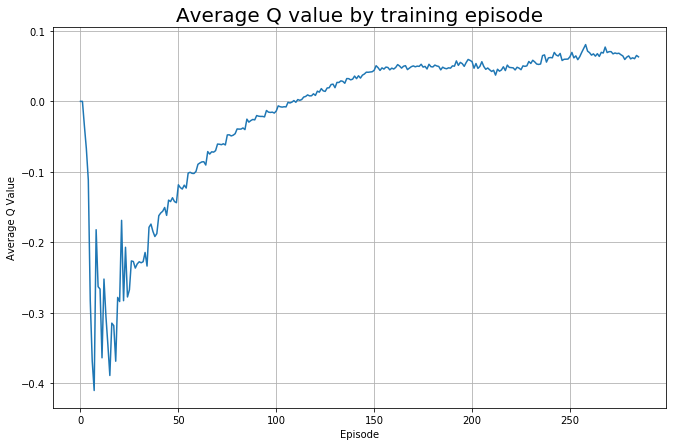

In [146]:
fig, ax = plt.subplots(figsize=(11,7))

ax.plot(df_train.episode, df_train.average_q, label = 'Average q value')
ax.set_title("Average Q value by training episode", fontsize=20)
ax.set_xlabel('Episode')
ax.set_ylabel('Average Q Value')
ax.grid()

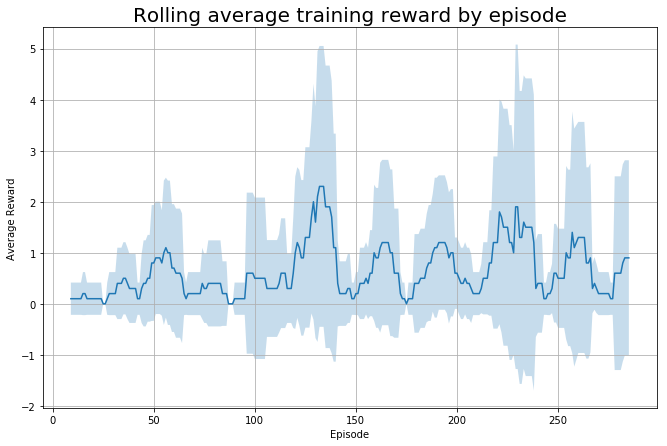

In [147]:
window = 10

mean = df_train['R'].rolling(window).mean()
sigma = df_train['R'].rolling(window).std()


fig, ax = plt.subplots(figsize=(11,7))
ax.plot(df.episode, mean, label='Average reward')
ax.fill_between(df.episode, mean+sigma, mean-sigma, alpha=0.25)
ax.set_title("Rolling average training reward by episode", fontsize=20)
#ax.legend(loc='upper left')
ax.set_xlabel('Episode')
ax.set_ylabel('Average Reward')
ax.grid()

In [148]:
df_scores = pd.read_csv(f"{filepath}scores.txt", sep="\t")
# prepend with e_ to signify evaluation
df_scores.columns = ['e_'+s for s in list(df_scores.columns)]
df_joined = df_train.join(df_scores.set_index('e_steps'), on='step')

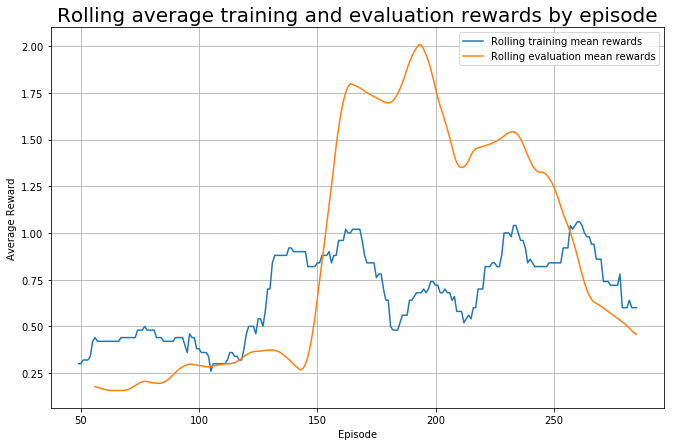

In [149]:
window = 50

train_mean = df_joined['R'].rolling(window).mean()
#one method, interpolate to skip over nans
eval_mean = df_joined['e_mean'].interpolate(method='linear').rolling(window).mean()

fig, ax = plt.subplots(figsize=(11,7))
ax.plot(df_joined.episode, train_mean, label = 'Rolling training mean rewards')
ax.plot(df_joined.episode, eval_mean, label = 'Rolling evaluation mean rewards')
ax.set_title("Rolling average training and evaluation rewards by episode", fontsize=20)
ax.legend()
ax.set_xlabel('Episode')
ax.set_ylabel('Average Reward')
ax.grid()

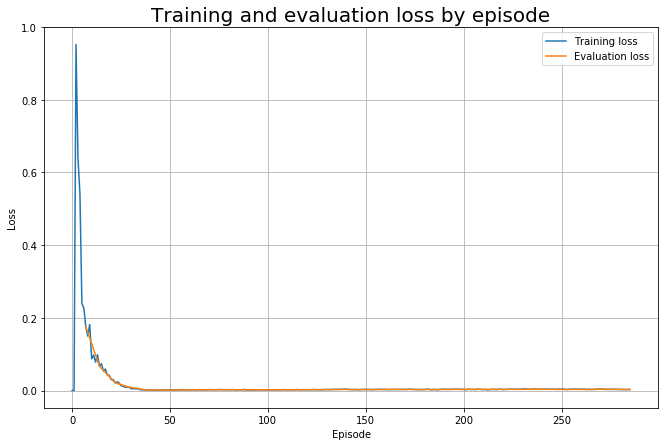

In [150]:
#method one, interpolation. I like this less
train_loss = df_joined['average_loss']
eval_loss = df_joined['e_average_loss'].interpolate(method='linear')

fig, ax = plt.subplots(figsize=(11,7))
ax.plot(df_joined.episode, train_loss, label = 'Training loss')
ax.plot(df_joined.episode, eval_loss, label = 'Evaluation loss')
ax.set_title("Training and evaluation loss by episode", fontsize=20)
ax.legend()
ax.set_xlabel('Episode')
ax.set_ylabel('Loss')
ax.grid()

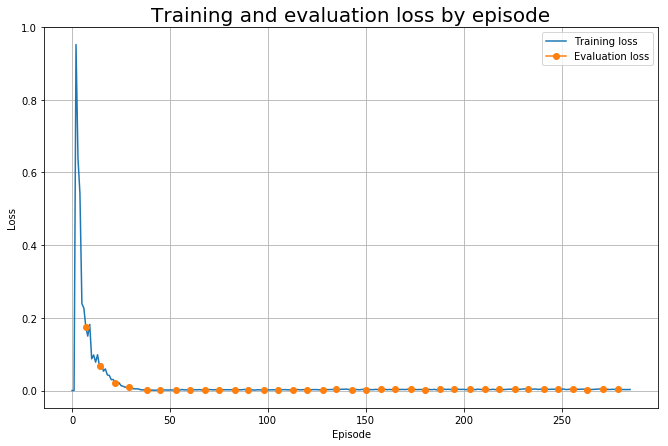

In [151]:
#method 2, plot with dots. I like this more

train_loss = df_joined['average_loss']
eval_loss = df_joined['e_average_loss']

fig, ax = plt.subplots(figsize=(11,7))
ax.plot(df_joined.episode, train_loss, label = 'Training loss')
ax.plot(df_joined.episode, eval_loss, 'o-', label = 'Evaluation loss')
ax.set_title("Training and evaluation loss by episode", fontsize=20)
ax.legend()
ax.set_xlabel('Episode')
ax.set_ylabel('Loss')
ax.grid()